# 8.1 本章の概要

* BF では音源に関する知識から推定した空間モデルのパラメータを必要とした
* 前章では音声のスパース性を仮定していたが、これはかなり大胆な過程で、実際には複数の音声が存在する時間周波数成分は多く存在する
* 特に残響が存在するシーンでは、スパース性に基づく音源分離は、性能劣化の懸念がある
* 前章の方法は、マイクロホン配置や目的音の到来方向に関する事前知識を利用したが、このような事前知識を必要としない音源分離法の方が、簡便さという点で望ましい
* 本章では、マイクロホン配置や目的音の方向などの情報が一切ない中で、音源ごとに音を分離する **ブラインド音源分離（BSS）** を扱う
* 空間モデルのパラメータを推定するための音源に関するモデルを確率・統計的なモデルとして導入
* パラメータを推定するための最適化法の一つである、最尤推定に基づき、音源分離のパラメータ推定は以下の最大化問題として位置づけられる$$\operatorname{maximize} \, \Sigma_{l=1}^{L} \Sigma_{k=1}^{K} \log p(x_{lk}|\theta)$$
* $\theta$ は音源分離に必要なパラメータ
* 上記の最大化問題を実行するためには、$p(x_{lk}|\theta)$ が具体的にどんな関数として記述できるかをモデリングすることが必要
* モデリング方法の先駆けが **独立成分分析（Independent Component Analysis: ICA）**
* ICA のパラメータ推定法として、勾配法や自然勾配法と呼ばれるパラメータ更新法が 2000 年代にかけて主流だった
* まず、自然勾配法に基づく ICA から見ていき、関連する様々な方法をさらう

# 8.2 独立成分分析

* 独立成分による分離フィルタの更新処理
* **周波数間パーミュテーション問題**：周波数ごとに音源分離をする際に、分離後の 2 つの信号のインデックスが不定になる問題
  * 音量の時間パターンの類似性に基づいてパーミュテーションを解く
  * `permutations` 関数を使って、あり得るすべての順序を出力
  * 音源数が増えるほど、順序の数が増えて計算量が大きくなる
  * $C_k$ が小さい順で周波数のインデックスを取り出すために、`argsort` 関数を使っている
* **プロジェクションバック**：大きさが不定になっている音源分離後の信号からマイクロホン位置での分離信号を得る処理
  * 分離した信号に分離フィルタの逆行列の列ベクトルをかけることで、マイクロホン位置での分離信号が得られる

## ICA、周波数間パーミュテーション解法、プロジェクションバックの同時実行

In [1]:
import wave
import pyroomacoustics as pa
import numpy as np
import scipy.signal as sp
import scipy as scipy
import matplotlib.pyplot as plt
from tabulate import tabulate

# 順列計算に使用
import itertools as itertools
import time

In [2]:
def plot_costs(n_iterations, *cost_buffs):
    plt.figure(figsize=(10, 5))

    cost_buff_names = ['ICA', 'IVA', 'IVA-IP', 'ILRMA-IP', 'LGM-EM', 'LGM-MM']
    for i, cost_buff in enumerate(cost_buffs):
        plt.plot(range(n_iterations), cost_buff, label=cost_buff_names[i])

    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost values for Blind Source Separation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
# コントラスト関数の微分（球対称ラプラス分布を仮定）
# s_hat: 分離信号(M, Nk, Lt)
def phi_laplacian(s_hat):
    norm = np.abs(s_hat)
    phi = s_hat / np.maximum(norm, 1.0e-18)
    return phi


# コントラスト関数（球対称ラプラス分布を仮定）
# s_hat: 分離信号(M, Nk, Lt)
def contrast_laplacian(s_hat):
    norm = 2.0 * np.abs(s_hat)
    return norm


# ICAによる分離フィルタ更新
# x:入力信号( M, Nk, Lt)
# W: 分離フィルタ(Nk,M,M)
# mu: 更新係数
# n_ica_iterations: 繰り返しステップ数
# phi_func: コントラスト関数の微分を与える関数
# contrast_func: コントラスト関数
# is_use_non_holonomic: True (非ホロノミック拘束を用いる） False (用いない）
# return W 分離フィルタ(Nk,M,M) s_hat 出力信号(M,Nk, Lt),cost_buff ICAのコスト (T)
def execute_natural_gradient_ica(x, W, phi_func=phi_laplacian, contrast_func=contrast_laplacian, mu=1.0, n_ica_iterations=20, is_use_non_holonomic=True):
    # マイクロホン数を取得する
    M = np.shape(x)[0]

    cost_buff = []
    for t in range(n_ica_iterations):
        # 音源分離信号を得る
        s_hat = np.einsum("kmn,nkt->mkt", W, x)

        # コントラスト関数を計算
        G = contrast_func(s_hat)

        # コスト計算
        cost = np.sum(np.mean(G, axis=-1)) - np.sum(2.0 * np.log(np.abs(np.linalg.det(W))))
        cost_buff.append(cost)

        # コンストラクト関数の微分を取得
        phi = phi_func(s_hat)

        phi_s = np.einsum("mkt,nkt->ktmn", phi, np.conjugate(s_hat))
        phi_s = np.mean(phi_s, axis=1)

        I = np.eye(M, M)
        if is_use_non_holonomic == False:
            deltaW = np.einsum("kmi,kin->kmn", I[None, ...] - phi_s, W)
        else:
            mask = (np.ones((M, M)) - I)[None, ...]
            deltaW = np.einsum("kmi,kin->kmn", np.multiply(mask, -phi_s), W)

        # フィルタを更新する
        W = W + mu * deltaW

    # 最後に出力信号を分離
    s_hat = np.einsum("kmn,nkt->mkt", W, x)

    return (W, s_hat, cost_buff)


# 周波数間の振幅相関に基づくパーミュテーション解法
# s_hat: M,Nk,Lt
# return permutation_index_result：周波数毎のパーミュテーション解
def solver_inter_frequency_permutation(s_hat):
    n_sources = np.shape(s_hat)[0]
    n_freqs = np.shape(s_hat)[1]
    n_frames = np.shape(s_hat)[2]

    s_hat_abs = np.abs(s_hat)

    norm_amp = np.sqrt(np.sum(np.square(s_hat_abs), axis=0, keepdims=True))
    s_hat_abs = s_hat_abs / np.maximum(norm_amp, 1.0e-18)

    spectral_similarity = np.einsum("mkt,nkt->k", s_hat_abs, s_hat_abs)

    frequency_order = np.argsort(spectral_similarity)

    # 音源間の相関が最も低い周波数からパーミュテーションを解く
    is_first = True
    permutations = list(itertools.permutations(range(n_sources)))
    permutation_index_result = {}

    for freq in frequency_order:
        if is_first == True:
            is_first = False

            # 初期値を設定する
            accumurate_s_abs = s_hat_abs[:, frequency_order[0], :]
            permutation_index_result[freq] = range(n_sources)
        else:
            max_correlation = 0
            max_correlation_perm = None
            for perm in permutations:
                s_hat_abs_temp = s_hat_abs[list(perm), freq, :]
                correlation = np.sum(accumurate_s_abs * s_hat_abs_temp)

                if max_correlation_perm is None:
                    max_correlation_perm = list(perm)
                    max_correlation = correlation
                elif max_correlation < correlation:
                    max_correlation = correlation
                    max_correlation_perm = list(perm)
            permutation_index_result[freq] = max_correlation_perm
            accumurate_s_abs += s_hat_abs[max_correlation_perm, freq, :]

    return permutation_index_result


# プロジェクションバックで最終的な出力信号を求める
# s_hat: M,Nk,Lt
# W: 分離フィルタ(Nk,M,M)
# retunr c_hat: マイクロホン位置での分離結果(M,M,Nk,Lt)
def projection_back(s_hat, W):
    # ステアリングベクトルを推定
    A = np.linalg.pinv(W)
    c_hat = np.einsum("kmi,ikt->mikt", A, s_hat)
    return c_hat


# 2バイトに変換してファイルに保存
# signal: time-domain 1d array (float)
# file_name: 出力先のファイル名
# sample_rate: サンプリングレート
def write_file_from_time_signal(signal, file_name, sample_rate):
    signal = signal.astype(np.int16)
    with wave.open(file_name, "w") as wave_out:
        wave_out.setnchannels(1)
        wave_out.setsampwidth(2)
        wave_out.setframerate(sample_rate)
        wave_out.writeframes(signal)


# SNRをはかる
# desired: 目的音、Lt
# out: 雑音除去後の信号 Lt
def calculate_snr(desired, out):
    wave_length = np.minimum(np.shape(desired)[0], np.shape(out)[0])

    # 消し残った雑音
    desired = desired[:wave_length]
    out = out[:wave_length]
    noise = desired - out
    snr = 10.0 * np.log10(np.sum(np.square(desired)) / np.sum(np.square(noise)))
    return snr


class SNRPost:
    """
    SNR_postを計算するためのクラス
    パーミュテーション問題への対処として、SNRが小さくなる方を正解とする
    """
    def __init__(self, multi_conv_data_l, multi_conv_data_r) -> None:
        self.multi_conv_data_l = multi_conv_data_l
        self.multi_conv_data_r = multi_conv_data_r

    def get(self, y):
        snr_post1 = calculate_snr(self.multi_conv_data_l[0, ...], y[0, ...]) + calculate_snr(self.multi_conv_data_r[0, ...], y[1, ...])
        snr_post2 = calculate_snr(self.multi_conv_data_l[0, ...], y[1, ...]) + calculate_snr(self.multi_conv_data_r[0, ...], y[0, ...])
        snr_post = np.maximum(snr_post1, snr_post2)
        return snr_post / 2.0


np.random.seed(0)

method:     ICA
Δsnr [dB]: 23.02
method:     ICA
Δsnr [dB]: 13.94


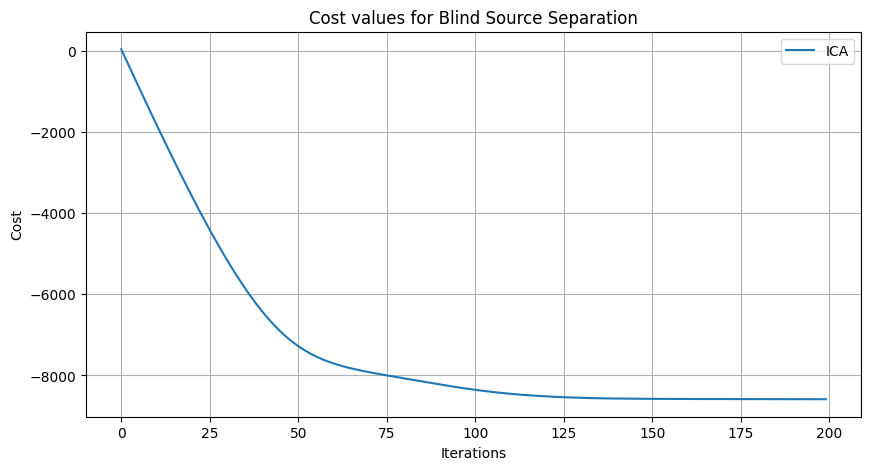

In [4]:
clean_wave_files = ["../arctic_a0001.wav", "../arctic_a0002.wav"]
n_sources = len(clean_wave_files)

# 長さを調べる
n_samples = 0
# ファイルを読み込む
for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    if n_samples < wav.getnframes():
        n_samples = wav.getnframes()
    wav.close()

clean_data = np.zeros([n_sources, n_samples])

# ファイルを読み込む
s = 0
for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max
    clean_data[s, : wav.getnframes()] = data
    wav.close()
    s = s + 1

# シミュレーションのパラメータ
# シミュレーションで用いる音源数
n_sim_sources = 2
# サンプリング周波数
sample_rate = 16000
# フレームサイズ
N = 1024
# 周波数の数
Nk = int(N / 2 + 1)
# 各ビンの周波数
freqs = np.arange(0, Nk, 1) * sample_rate / N
# 音声と雑音との比率 [dB]
SNR = 90.0

# 部屋の大きさ
room_dim = np.r_[10.0, 10.0, 10.0]
# マイクロホンアレイを置く部屋の場所
mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1
# マイクロホンアレイのマイク配置
mic_directions = np.array([[np.pi / 2.0, theta / 180.0 * np.pi] for theta in np.arange(180, 361, 180)])

distance = 0.01
mic_alignments = np.zeros((3, mic_directions.shape[0]), dtype=mic_directions.dtype)
mic_alignments[0, :] = np.cos(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[1, :] = np.sin(mic_directions[:, 1]) * np.sin(mic_directions[:, 0])
mic_alignments[2, :] = np.cos(mic_directions[:, 0])
mic_alignments *= distance

# マイクロホン数
n_channels = np.shape(mic_alignments)[1]

# マイクロホンアレイの座標
R = mic_alignments + mic_array_loc[:, None]

for is_use_reverb in [False, True]:

    if is_use_reverb == False:
        # 部屋を生成する
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

    else:
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)

    # 用いるマイクロホンアレイの情報を設定する
    room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_left.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_right.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

    # 音源の場所
    doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0]])

    # 音源とマイクロホンの距離
    distance = 1.0

    source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
    source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[2, :] = np.cos(doas[:, 0])
    source_locations *= distance
    source_locations += mic_array_loc[:, None]

    # 各音源をシミュレーションに追加する
    for s in range(n_sim_sources):
        clean_data[s] /= np.std(clean_data[s])
        room.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 0:
            room_no_noise_left.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 1:
            room_no_noise_right.add_source(source_locations[:, s], signal=clean_data[s])

    # シミュレーションを回す
    room.simulate(snr=SNR)
    room_no_noise_left.simulate(snr=90)
    room_no_noise_right.simulate(snr=90)

    # 畳み込んだ波形を取得する(チャンネル、サンプル）
    multi_conv_data = room.mic_array.signals
    multi_conv_data_left_no_noise = room_no_noise_left.mic_array.signals
    multi_conv_data_right_no_noise = room_no_noise_right.mic_array.signals

    snr_post = SNRPost(multi_conv_data_left_no_noise, multi_conv_data_right_no_noise)

    # 畳み込んだ波形をファイルに書き込む
    write_file_from_time_signal(multi_conv_data_left_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_left_clean.wav", sample_rate)
    write_file_from_time_signal(multi_conv_data_right_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_right_clean.wav", sample_rate)

    # 畳み込んだ波形をファイルに書き込む
    write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_in_left.wav", sample_rate)
    write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_in_right.wav", sample_rate)

    # 短時間フーリエ変換を行う
    f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

    # ICAの繰り返し回数
    n_ica_iterations = 200

    # ICAの分離フィルタを初期化
    Wica = np.zeros(shape=(Nk, n_sources, n_sources), dtype=complex)
    Wica = Wica + np.eye(n_sources)[None, ...]

    Wica, s_ica, cost_buff = execute_natural_gradient_ica(stft_data, Wica, mu=0.1, n_ica_iterations=n_ica_iterations, is_use_non_holonomic=False)
    permutation_index_result = solver_inter_frequency_permutation(s_ica)
    y_ica = projection_back(s_ica, Wica)

    # パーミュテーションを解く
    for k in range(Nk):
        y_ica[:, :, k, :] = y_ica[:, permutation_index_result[k], k, :]

    t, y_ica = sp.istft(y_ica[0, ...], fs=sample_rate, window="hann", nperseg=N)

    snr_pre = calculate_snr(multi_conv_data_left_no_noise[0, ...], multi_conv_data[0, ...]) + \
            calculate_snr(multi_conv_data_right_no_noise[0, ...], multi_conv_data[0, ...])
    snr_pre /= 2.0

    snr_ica_post = snr_post.get(y_ica)

    write_file_from_time_signal(y_ica[0, ...] * np.iinfo(np.int16).max / 20.0, "./ica_1.wav", sample_rate)
    write_file_from_time_signal(y_ica[1, ...] * np.iinfo(np.int16).max / 20.0, "./ica_2.wav", sample_rate)

    print("method:    ", "ICA")
    print(f"Δsnr [dB]: {(snr_ica_post - snr_pre):.2f}")

# コストの値を表示
plot_costs(n_ica_iterations, cost_buff)

* 7 章の、スパース性と BF の統合で性能がトップだった MVDR (Δsnr = 14.78 dB) と比較して、ICA は Δsnr = 23.02 dB と大幅に性能が向上している
* 残響があるときも、MVDR の Δsnr = 11.49 dB に対して、ICA は Δsnr = 14.80 dB と、残響なしよりは性能が劣化するが、BF と比較して性能が改善
* ICA はマイクロホン配置や目的音の到来方向という情報は使わないものの、データのみから音源モデルの情報をもとに空間モデルを精度よく推定できる
* しかし、自然勾配法ではパラメータ更新回数がとても多く、計算量がネックになる
* 周波数間パーミュテーションを最後に行っているが、分離フィルタの更新時に他の周波数の情報を利用しないのは非効率

# 7.3 独立ベクトル分析

* ICA では周波数ごとに音源分離を行うため、周波数パーミュテーション問題を解くことが必要だった
* **独立ベクトル分析（Independent Vector Analysis: IVA）** は、全周波数の音源分離を同時に行うことで、周波数間パーミュテーション問題を解くことなく、音源分離を行う手法
* Iterative Projection(IP) 法：分離フィルタの更新のための繰り返し計算を減らすために近年提案されている手法
  * 最適化法の一つの MM 法を適用してパラメータを更新
  * コスト関数が単調減少することが原理的に保証されている
* ICA と IVA の違い：コントラスト関数
  * ICA では、コントラスト関数を周波数ごとに独立な関数として定義
  * IVA では、全周波数をまとめたベクトルに対して一つのコントラスト関数を定義 = すべての周波数成分が同じ分散を有していると仮定
* IP 法に基づく IVA のパラメータ更新法（AuxIVA）

In [5]:
# コントラスト関数の微分（球対称多次元ラプラス分布を仮定）
# s_hat: 分離信号(M, Nk, Lt)
def phi_multivariate_laplacian(s_hat):
    power = np.square(np.abs(s_hat))
    norm = np.sqrt(np.sum(power, axis=1, keepdims=True))

    phi = s_hat / np.maximum(norm, 1.0e-18)
    return phi


# コントラスト関数（球対称多次元ラプラス分布を仮定）
# s_hat: 分離信号(M, Nk, Lt)
def contrast_multivariate_laplacian(s_hat):
    power = np.square(np.abs(s_hat))
    norm = 2.0 * np.sqrt(np.sum(power, axis=1, keepdims=True))

    return norm


# IP法による分離フィルタ更新
# x:入力信号( M, Nk, Lt)
# W: 分離フィルタ(Nk,M,M)
# n_iterations: 繰り返しステップ数
# return W 分離フィルタ(Nk,M,M) s_hat 出力信号(M,Nk, Lt),cost_buff コスト (T)
def execute_ip_multivariate_laplacian_iva(x, W, n_iterations=20):
    # マイクロホン数を取得する
    M = np.shape(x)[0]

    cost_buff = []
    for t in range(n_iterations):
        # 音源分離信号を得る
        s_hat = np.einsum("kmn,nkt->mkt", W, x)

        # 補助変数を更新する
        v = np.sqrt(np.sum(np.square(np.abs(s_hat)), axis=1))

        # コントラスト関数を計算
        G = contrast_multivariate_laplacian(s_hat)

        # コスト計算
        cost = np.sum(np.mean(G, axis=-1)) - np.sum(2.0 * np.log(np.abs(np.linalg.det(W))))
        cost_buff.append(cost)

        # IP法による更新
        Q = np.einsum("st,mkt,nkt->tksmn", 1.0 / np.maximum(v, 1.0e-18), x, np.conjugate(x))
        Q = np.average(Q, axis=0)

        for source_index in range(M):
            WQ = np.einsum("kmi,kin->kmn", W, Q[:, source_index, :, :])
            invWQ = np.linalg.pinv(WQ)
            W[:, source_index, :] = np.conjugate(invWQ[:, :, source_index])
            wVw = np.einsum("km,kmn,kn->k", W[:, source_index, :], Q[:, source_index, :, :], np.conjugate(W[:, source_index, :]))
            wVw = np.sqrt(np.abs(wVw))
            W[:, source_index, :] = W[:, source_index, :] / np.maximum(wVw[:, None], 1.0e-18)

    s_hat = np.einsum("kmn,nkt->mkt", W, x)

    return (W, s_hat, cost_buff)

Method      Processing Time (sec)    Δsnr (dB)
--------  -----------------------  -----------
NG-ICA                       0.30         2.22
NG-IVA                       0.29         2.18
AuxIVA                       0.49        18.79 

Method      Processing Time (sec)    Δsnr (dB)
--------  -----------------------  -----------
NG-ICA                       0.33         1.67
NG-IVA                       0.32         2.12
AuxIVA                       0.53        12.65 



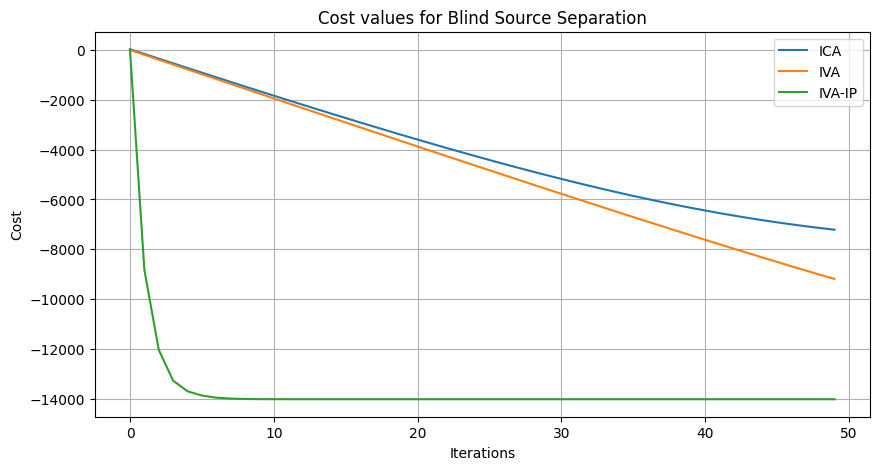

In [6]:
for is_use_reverb in [False, True]:

    if is_use_reverb == False:
        # 部屋を生成する
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

    else:
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)

    # 用いるマイクロホンアレイの情報を設定する
    room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_left.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_right.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

    # 音源の場所
    doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0]])

    # 音源とマイクロホンの距離
    distance = 1.0

    source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
    source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[2, :] = np.cos(doas[:, 0])
    source_locations *= distance
    source_locations += mic_array_loc[:, None]

    # 各音源をシミュレーションに追加する
    for s in range(n_sim_sources):
        clean_data[s] /= np.std(clean_data[s])
        room.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 0:
            room_no_noise_left.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 1:
            room_no_noise_right.add_source(source_locations[:, s], signal=clean_data[s])

    # シミュレーションを回す
    room.simulate(snr=SNR)
    room_no_noise_left.simulate(snr=90)
    room_no_noise_right.simulate(snr=90)

    # 畳み込んだ波形を取得する(チャンネル、サンプル）
    multi_conv_data = room.mic_array.signals
    multi_conv_data_left_no_noise = room_no_noise_left.mic_array.signals
    multi_conv_data_right_no_noise = room_no_noise_right.mic_array.signals

    snr_post = SNRPost(multi_conv_data_left_no_noise, multi_conv_data_right_no_noise)

    # 畳み込んだ波形をファイルに書き込む
    write_file_from_time_signal(multi_conv_data_left_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_left_clean.wav", sample_rate)
    write_file_from_time_signal(multi_conv_data_right_no_noise[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_right_clean.wav", sample_rate)
    write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_in_left.wav", sample_rate)
    write_file_from_time_signal(multi_conv_data[0, :] * np.iinfo(np.int16).max / 20.0, "./ica_in_right.wav", sample_rate)

    # 短時間フーリエ変換を行う
    f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

    # ICAの繰り返し回数
    n_ica_iterations = 50

    # ICAの分離フィルタを初期化
    Wica = np.zeros(shape=(Nk, n_sources, n_sources), dtype=complex)
    Wica = Wica + np.eye(n_sources)[None, ...]

    Wiva = Wica.copy()
    Wiva_ip = Wica.copy()

    # ICA実行コード
    t0 = time.time()
    Wica, s_ica, cost_buff_ica = execute_natural_gradient_ica(stft_data, Wica, mu=0.1, n_ica_iterations=n_ica_iterations, is_use_non_holonomic=False)
    permutation_index_result = solver_inter_frequency_permutation(s_ica)
    y_ica = projection_back(s_ica, Wica)
    # パーミュテーションを解く
    for k in range(Nk):
        y_ica[:, :, k, :] = y_ica[:, permutation_index_result[k], k, :]
    ica_time = time.time() - t0

    # 自然勾配法に基づくIVA実行コード（引数に与える関数を変更するだけ)
    t0 = time.time()
    Wiva, s_iva, cost_buff_iva = execute_natural_gradient_ica(
        stft_data,
        Wiva,
        phi_func=phi_multivariate_laplacian,
        contrast_func=contrast_multivariate_laplacian,
        mu=0.1,
        n_ica_iterations=n_ica_iterations,
        is_use_non_holonomic=False,
    )
    y_iva = projection_back(s_iva, Wiva)
    iva_time = time.time() - t0

    # IP法に基づくIVA実行コード（引数に与える関数を変更するだけ)
    t0 = time.time()
    Wiva_ip, s_iva_ip, cost_buff_iva_ip = execute_ip_multivariate_laplacian_iva(stft_data, Wiva_ip, n_iterations=n_ica_iterations)
    y_iva_ip = projection_back(s_iva_ip, Wiva_ip)
    iva_ip_time = time.time() - t0

    t, y_ica = sp.istft(y_ica[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_iva = sp.istft(y_iva[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_iva_ip = sp.istft(y_iva_ip[0, ...], fs=sample_rate, window="hann", nperseg=N)

    snr_pre = calculate_snr(multi_conv_data_left_no_noise[0, ...], multi_conv_data[0, ...]) + \
            calculate_snr(multi_conv_data_right_no_noise[0, ...], multi_conv_data[0, ...])
    snr_pre /= 2.0

    snr_ica_post = snr_post.get(y_ica)
    snr_iva_post = snr_post.get(y_iva)
    snr_iva_ip_post = snr_post.get(y_iva_ip)

    write_file_from_time_signal(y_iva[0, ...] * np.iinfo(np.int16).max / 20.0, "./iva_1.wav", sample_rate)
    write_file_from_time_signal(y_iva[1, ...] * np.iinfo(np.int16).max / 20.0, "./iva_2.wav", sample_rate)

    write_file_from_time_signal(y_iva_ip[0, ...] * np.iinfo(np.int16).max / 20.0, "./iva_ip_1.wav", sample_rate)
    write_file_from_time_signal(y_iva_ip[1, ...] * np.iinfo(np.int16).max / 20.0, "./iva_ip_2.wav", sample_rate)

    data = [
        ["NG-ICA", "NG-IVA", "AuxIVA"],
        [ica_time, iva_time, iva_ip_time],
        [snr_ica_post - snr_pre, snr_iva_post - snr_pre, snr_iva_ip_post - snr_pre]
    ]

    headers = ["Method", "Processing Time (sec)", "Δsnr (dB)"]
    table = tabulate(zip(*data), headers=headers, floatfmt=".2f")
    print(table, "\n")

# コストの値を表示
plot_costs(n_ica_iterations, cost_buff_ica, cost_buff_iva, cost_buff_iva_ip)

* 図からわかるように、AuxIVA は収束が速く、SNR 改善率も ICA, IVA と比べて高い

# 7.4 独立低ランク分析

* IVA では全周波数成分が時間ごとに同じ分散を持つ（すべての周波数が同時に大きく・小さくなる）ことを仮定していたが、これは本当に妥当な仮説か？
* 実は、全周波数成分が時間ごとに同じ分散を持つというのはとても大雑把な仮定
* この過程を変更し、より音声の周波数構造のモデルに近くなるような音源分離法が提案されている：**独立低ランク分析（Independent Low-Rank Analysis: ILRA）**
* ILRMA では、各音源の時間周波数ごとの分散をモデリング
* 周波数構造のパターンを複数持つことにより、時間帯ごとに周波数構造のパターンが変化する音声のスペクトログラムに推定した時間周波数ごとの分散を、よりよく適合させることが可能になる

In [7]:
# IP法による分離フィルタ更新
# x:入力信号( M, Nk, Lt)
# W: 分離フィルタ(Nk,M,M)
# a: アクティビティ(B,M,Lt)
# b: 基底(Nk,M,B)
# n_iterations: 繰り返しステップ数
# return W 分離フィルタ(Nk,M,M) s_hat 出力信号(M,Nk, Lt),cost_buff コスト (T)
def execute_ip_time_varying_gaussian_ilrma(x, W, a, b, n_iterations=20):
    # マイクロホン数・周波数・フレーム数を取得する
    M = np.shape(x)[0]
    Nk = np.shape(x)[1]
    Lt = np.shape(x)[2]

    cost_buff = []
    for t in range(n_iterations):
        # 音源分離信号を得る
        s_hat = np.einsum("kmn,nkt->mkt", W, x)
        s_power = np.square(np.abs(s_hat))

        # 時間周波数分散を更新
        v = np.einsum("bst,ksb->skt", a, b)

        # アクティビティの更新
        a = a * np.sqrt(np.einsum("ksb,skt->bst", b, s_power / np.maximum(v, 1.0e-18) ** 2) / np.einsum("ksb,skt->bst", b, 1.0 / np.maximum(v, 1.0e-18)))

        # 基底の更新
        b = b * np.sqrt(np.einsum("bst,skt->ksb", a, s_power / np.maximum(v, 1.0e-18) ** 2) / np.einsum("bst,skt->ksb", a, 1.0 / np.maximum(v, 1.0e-18)))

        # 時間周波数分散を再度更新
        v = np.einsum("bst,ksb->skt", a, b)

        # コスト計算
        cost = np.sum(np.mean(s_power / np.maximum(v, 1.0e-18) + np.log(v), axis=-1)) - np.sum(2.0 * np.log(np.abs(np.linalg.det(W))))
        cost_buff.append(cost)

        # IP法による更新
        Q = np.einsum("skt,mkt,nkt->tksmn", 1.0 / np.maximum(v, 1.0e-18), x, np.conjugate(x))
        Q = np.average(Q, axis=0)

        for source_index in range(M):
            WQ = np.einsum("kmi,kin->kmn", W, Q[:, source_index, :, :])
            invWQ = np.linalg.pinv(WQ)
            W[:, source_index, :] = np.conjugate(invWQ[:, :, source_index])
            wVw = np.einsum("km,kmn,kn->k", W[:, source_index, :], Q[:, source_index, :, :], np.conjugate(W[:, source_index, :]))
            wVw = np.sqrt(np.abs(wVw))
            W[:, source_index, :] = W[:, source_index, :] / np.maximum(wVw[:, None], 1.0e-18)

    s_hat = np.einsum("kmn,nkt->mkt", W, x)

    return (W, s_hat, cost_buff)

Method      Processing Time (sec)    Δsnr (dB)
--------  -----------------------  -----------
NG-ICA                       0.27         2.21
NG-IVA                       0.25         2.18
AuxIVA                       0.46        18.87
ILRMA                        0.82        31.77
ILRMA-1                      0.74        26.43
ILRMA-2                      0.76        31.57
ILRMA-3                      0.77        31.62
ILRMA-4                      0.82        31.77 

Method      Processing Time (sec)    Δsnr (dB)
--------  -----------------------  -----------
NG-ICA                       0.34         1.79
NG-IVA                       0.33         2.12
AuxIVA                       0.57        12.71
ILRMA                        0.98        14.54
ILRMA-1                      0.95        13.50
ILRMA-2                      1.01        14.54
ILRMA-3                      0.98        14.62
ILRMA-4                      0.98        14.54 

2


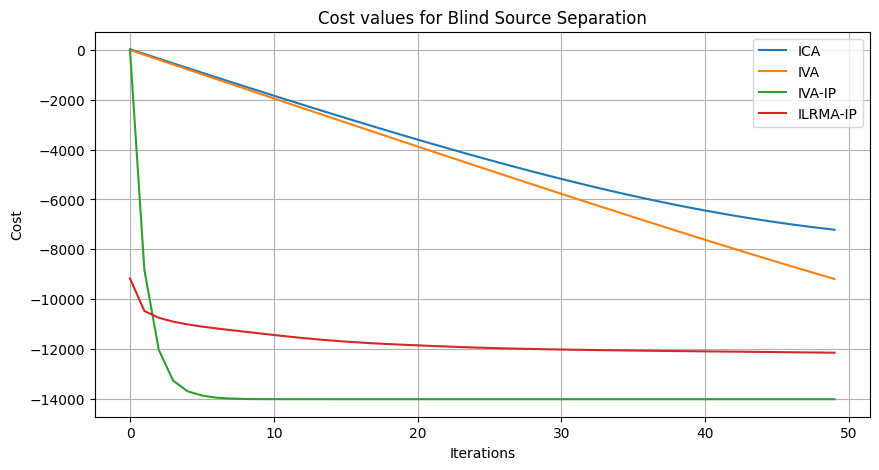

In [8]:
for is_use_reverb in [False, True]:

    if is_use_reverb == False:
        # 部屋を生成する
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

    else:
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)

    # 用いるマイクロホンアレイの情報を設定する
    room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_left.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_right.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

    # 音源の場所
    doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0]])

    # 音源とマイクロホンの距離
    distance = 1.0

    source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
    source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[2, :] = np.cos(doas[:, 0])
    source_locations *= distance
    source_locations += mic_array_loc[:, None]

    # 各音源をシミュレーションに追加する
    for s in range(n_sim_sources):
        clean_data[s] /= np.std(clean_data[s])
        room.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 0:
            room_no_noise_left.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 1:
            room_no_noise_right.add_source(source_locations[:, s], signal=clean_data[s])

    # シミュレーションを回す
    room.simulate(snr=SNR)
    room_no_noise_left.simulate(snr=90)
    room_no_noise_right.simulate(snr=90)

    # 畳み込んだ波形を取得する(チャンネル、サンプル）
    multi_conv_data = room.mic_array.signals
    multi_conv_data_left_no_noise = room_no_noise_left.mic_array.signals
    multi_conv_data_right_no_noise = room_no_noise_right.mic_array.signals

    snr_post = SNRPost(multi_conv_data_left_no_noise, multi_conv_data_right_no_noise)

    # 短時間フーリエ変換を行う
    f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

    # 処理するフレーム数
    Lt = np.shape(stft_data)[-1]

    # ICAの繰り返し回数
    n_ica_iterations = 50

    # ICAの分離フィルタを初期化
    Wica = np.zeros(shape=(Nk, n_sources, n_sources), dtype=complex)
    Wica = Wica + np.eye(n_sources)[None, ...]
    Wiva = Wica.copy()
    Wiva_ip = Wica.copy()
    Wilrma_ip = Wica.copy()

    # 自然勾配法に基づくICA実行コード
    t0 = time.time()
    Wica, s_ica, cost_buff_ica = execute_natural_gradient_ica(stft_data, Wica, mu=0.1, n_ica_iterations=n_ica_iterations, is_use_non_holonomic=False)
    permutation_index_result = solver_inter_frequency_permutation(s_ica)
    y_ica = projection_back(s_ica, Wica)
    # パーミュテーションを解く
    for k in range(Nk):
        y_ica[:, :, k, :] = y_ica[:, permutation_index_result[k], k, :]
    ica_time = time.time() - t0

    # 自然勾配法に基づくIVA実行コード
    t0 = time.time()
    Wiva, s_iva, cost_buff_iva = execute_natural_gradient_ica(
        stft_data,
        Wiva,
        phi_func=phi_multivariate_laplacian,
        contrast_func=contrast_multivariate_laplacian,
        mu=0.1,
        n_ica_iterations=n_ica_iterations,
        is_use_non_holonomic=False,
    )
    y_iva = projection_back(s_iva, Wiva)
    iva_time = time.time() - t0

    # IP法に基づくIVA実行コード
    t0 = time.time()
    Wiva_ip, s_iva_ip, cost_buff_iva_ip = execute_ip_multivariate_laplacian_iva(stft_data, Wiva_ip, n_iterations=n_ica_iterations)
    y_iva_ip = projection_back(s_iva_ip, Wiva_ip)
    iva_ip_time = time.time() - t0

    t, y_ica = sp.istft(y_ica[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_iva = sp.istft(y_iva[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_iva_ip = sp.istft(y_iva_ip[0, ...], fs=sample_rate, window="hann", nperseg=N)

    snr_pre = calculate_snr(multi_conv_data_left_no_noise[0, ...], multi_conv_data[0, ...]) + \
              calculate_snr(multi_conv_data_right_no_noise[0, ...], multi_conv_data[0, ...])
    snr_pre /= 2.0

    snr_ica_post = snr_post.get(y_ica)
    snr_iva_post = snr_post.get(y_iva)
    snr_iva_ip_post = snr_post.get(y_iva_ip)

    # ILRMAの基底数を1から4まで変化させて実験
    ilrma_ip_times = []
    delta_snr_ilrma_ip_posts = []
    cost_buff_ilrma_ips = []

    for n_basis in range(1, 5):
        b = np.ones(shape=(Nk, n_sources, n_basis))
        a = np.random.uniform(size=(n_basis * n_sources * Lt))
        a = np.reshape(a, (n_basis, n_sources, Lt))

        # IP法に基づくILRMA実行コード
        t0 = time.time()
        Wilrma_ip, s_ilrma_ip, cost_buff_ilrma_ip = execute_ip_time_varying_gaussian_ilrma(stft_data, Wilrma_ip, a, b, n_iterations=n_ica_iterations)
        cost_buff_ilrma_ips.append(cost_buff_ilrma_ip)
        y_ilrma_ip = projection_back(s_ilrma_ip, Wilrma_ip)
        ilrma_ip_time = time.time() - t0
        ilrma_ip_times.append(ilrma_ip_time)

        t, y_ilrma_ip = sp.istft(y_ilrma_ip[0, ...], fs=sample_rate, window="hann", nperseg=N)
        snr_ilrma_ip_post = snr_post.get(y_ilrma_ip)
        delta_snr_ilrma_ip_posts.append(snr_ilrma_ip_post - snr_pre)

        write_file_from_time_signal(y_ilrma_ip[0, ...] * np.iinfo(np.int16).max / 20.0, f"./ilrma_ip_{n_basis}.wav", sample_rate)
        write_file_from_time_signal(y_ilrma_ip[1, ...] * np.iinfo(np.int16).max / 20.0, f"./ilrma_ip_{n_basis}.wav", sample_rate)

    data = [
        ["NG-ICA", "NG-IVA", "AuxIVA", "ILRMA"] + ["ILRMA-{}".format(i) for i in range(1, 5)],
        [ica_time, iva_time, iva_ip_time, ilrma_ip_time] + ilrma_ip_times,
        [snr_ica_post - snr_pre, snr_iva_post - snr_pre, snr_iva_ip_post - snr_pre, snr_ilrma_ip_post - snr_pre] + delta_snr_ilrma_ip_posts
    ]

    headers = ["Method", "Processing Time (sec)", "Δsnr (dB)"]
    table = tabulate(zip(*data), headers=headers, floatfmt=".2f")
    print(table, "\n")

# コストの値を表示
print(np.argmax(delta_snr_ilrma_ip_posts))
cost_buff_ilrma_ip = cost_buff_ilrma_ips[np.argmax(delta_snr_ilrma_ip_posts)]
plot_costs(n_ica_iterations, cost_buff_ica, cost_buff_iva, cost_buff_iva_ip, cost_buff_ilrma_ip)

* ILRMA で周波数パターン数を 2 もしくは 3 にするのがよさそう

# 7.5 マルチチャンネル時変ガウスモデル

* **マルチチャンネル時変ガウスモデル（Local Gaussian Modeling: LGM）**：ガウス分布を用いた、とても単純かつ音声の分離も可能な手法
* ガウス分布はカルマンフィルタなどの他の信号処理とも融合させやすく、拡張性に富んでいて使い勝手がいい分布
* LGM は ICA や IVA と異なり、音源数がマイクロホン素子数と等しいと仮定する必要がない
  * 音源数がマイクロホン素子数を上回っている場合でも適用可能
* EM アルゴリズムと補助関数のそれぞれを用いて LGM のパラメータ推定を実行

In [9]:
# EM法によるLGMのパラメータ推定法
# x:入力信号( M, Nk, Lt)
# Ns: 音源数
# n_iterations: 繰り返しステップ数
# return R 共分散行列(Nk,Ns,M,M) v 時間周波数分散(Nk,Ns,Lt),c_bar 音源分離信号(M,Ns,Nk,Lt), cost_buff コスト (T)
def execute_em_lgm(x, Ns=2, n_iterations=20):
    # マイクロホン数・周波数・フレーム数を取得する
    M = np.shape(x)[0]
    Nk = np.shape(x)[1]
    Lt = np.shape(x)[2]

    # Rとvを初期化する
    mask = np.random.uniform(size=Nk * Ns * Lt)
    mask = np.reshape(mask, (Nk, Ns, Lt))
    R = np.einsum("kst,mkt,nkt->kstmn", mask, x, np.conjugate(x))
    R = np.average(R, axis=2)
    v = np.random.uniform(size=Nk * Ns * Lt)
    v = np.reshape(v, (Nk, Ns, Lt))

    cost_buff = []
    for t in range(n_iterations):
        # 入力信号の共分散行列を求める
        vR = np.einsum("kst,ksmn->kstmn", v, R)
        V = np.sum(vR, axis=1)
        V_inverse = np.linalg.pinv(V)

        # コスト計算
        cost = np.sum(np.einsum("mkt,ktmn,nkt->kt", np.conjugate(x), V_inverse, x) + np.log(np.abs(np.linalg.det(V))))
        cost /= float(Lt)
        cost = np.real(cost)
        cost_buff.append(cost)

        Wmwf = np.einsum("kstmi,ktin->kstmn", vR, V_inverse)

        # 事後確率計算に必要なパラメータを推定
        c_bar = np.einsum("kstmn,nkt->kstm", Wmwf, x)
        R_bar = np.einsum("kstmi,kstin->kstmn", -1.0 * Wmwf + np.eye(M), vR)
        P_bar = R_bar + np.einsum("kstm,kstn->kstmn", c_bar, np.conjugate(c_bar))

        # パラメータを更新
        R = np.average(P_bar / np.maximum(v, 1.0e-18)[..., None, None], axis=2)

        R_inverse = np.linalg.pinv(R)
        v = np.einsum("ksmi,kstim->kst", R_inverse, P_bar)
        v = v / float(M)

    vR = np.einsum("kst,ksmn->kstmn", v, R)
    V = np.sum(vR, axis=1)
    V_inverse = np.linalg.pinv(V)
    Wmwf = np.einsum("kstmi,ktin->kstmn", vR, V_inverse)

    # 音源分離信号を得る
    c_bar = np.einsum("kstmn,nkt->mskt", Wmwf, x)

    return (R, v, c_bar, cost_buff)


# IP法によるLGMのパラメータ推定法
# x:入力信号( M, Nk, Lt)
# Ns: 音源数
# n_iterations: 繰り返しステップ数
# return R 共分散行列(Nk,Ns,M,M) v 時間周波数分散(Nk,Ns,Lt),c_bar 音源分離信号(M,Ns,Nk,Lt), cost_buff コスト (T)
def execute_mm_lgm(x, Ns=2, n_iterations=20):
    # マイクロホン数・周波数・フレーム数を取得する
    M = np.shape(x)[0]
    Nk = np.shape(x)[1]
    Lt = np.shape(x)[2]

    # Rとvを初期化する
    mask = np.random.uniform(size=Nk * Ns * Lt)
    mask = np.reshape(mask, (Nk, Ns, Lt))
    R = np.einsum("kst,mkt,nkt->kstmn", mask, x, np.conjugate(x))
    R = np.average(R, axis=2)
    v = np.random.uniform(size=Nk * Ns * Lt)
    v = np.reshape(v, (Nk, Ns, Lt))

    cost_buff = []
    for t in range(n_iterations):
        # 入力信号の共分散行列を求める
        vR = np.einsum("kst,ksmn->kstmn", v, R)
        V = np.sum(vR, axis=1)
        V_inverse = np.linalg.pinv(V)

        # コスト計算
        cost = np.sum(np.einsum("mkt,ktmn,nkt->kt", np.conjugate(x), V_inverse, x) + np.log(np.abs(np.linalg.det(V))))
        cost /= float(Lt)
        cost = np.real(cost)
        cost_buff.append(cost)

        # パラメータを更新

        # Rの更新
        V_inverseX = np.einsum("ktmn,nkt->ktm", V_inverse, x)
        V_inverseXV_inverseX = np.einsum("ktm,ktn->ktmn", V_inverseX, np.conjugate(V_inverseX))
        A = np.einsum("kst,ktmn->ksmn", v, V_inverse)
        B = np.einsum("kst,ktmn->ksmn", v, V_inverseXV_inverseX)
        RBR = np.einsum("ksmn,ksni,ksij->ksmj", R, B, R)
        invA = np.linalg.pinv(A)
        A_RBR = np.matmul(A, RBR)
        R = np.concatenate(
            [
                np.concatenate([np.matmul(invA[k, s, ...], scipy.linalg.sqrtm(A_RBR[k, s, ...]))[None, None, ...] for k in range(Nk)], axis=0)
                for s in range(Ns)
            ],
            axis=1,
        )
        R = (R + np.transpose(np.conjugate(R), [0, 1, 3, 2])) / (2.0 + 0.0j)

        # vの更新
        v = v * np.sqrt(
            np.einsum("ktm,ktn,ksnm->kst", V_inverseX, np.conjugate(V_inverseX), R) / np.maximum(np.einsum("ktmn,ksnm->kst", V_inverse, R), 1.0e-18)
        )

    vR = np.einsum("kst,ksmn->kstmn", v, R)
    V = np.sum(vR, axis=1)
    V_inverse = np.linalg.pinv(V)
    Wmwf = np.einsum("kstmi,ktin->kstmn", vR, V_inverse)

    # 音源分離信号を得る
    c_bar = np.einsum("kstmn,nkt->mskt", Wmwf, x)

    return (R, v, c_bar, cost_buff)

Method      Processing Time (sec)    Δsnr (dB)
--------  -----------------------  -----------
NG-ICA                       0.31         2.27
NG-IVA                       0.44         2.18
AuxIVA                       0.27        18.70
ILRMA                        0.84        26.80
LGM-EM                       8.98        14.78
LGM-MM                       9.59        25.98 

Method      Processing Time (sec)    Δsnr (dB)
--------  -----------------------  -----------
NG-ICA                       0.32         1.51
NG-IVA                       0.48         2.12
AuxIVA                       0.30        12.59
ILRMA                        0.90         9.02
LGM-EM                      10.00         7.46
LGM-MM                      10.34        12.38 



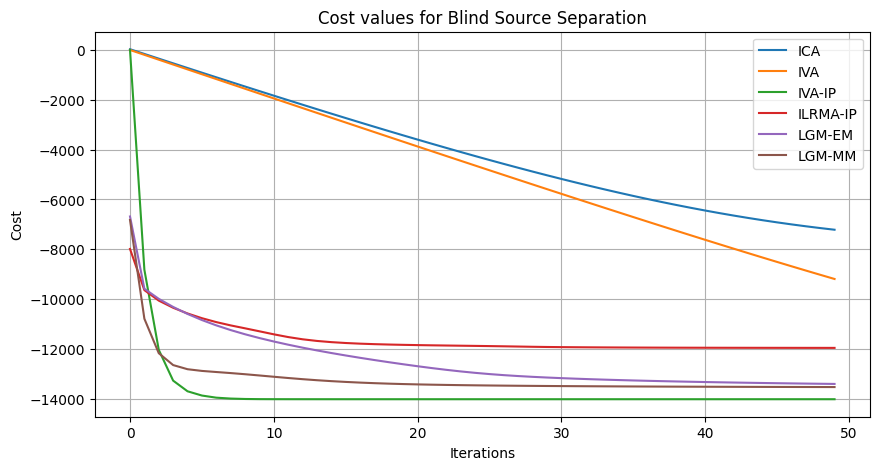

In [10]:
for is_use_reverb in [False, True]:

    if is_use_reverb == False:
        # 部屋を生成する
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)

    else:
        room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_left = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)
        room_no_noise_right = pa.ShoeBox(room_dim, fs=sample_rate, max_order=17, absorption=0.4)

    # 用いるマイクロホンアレイの情報を設定する
    room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_left.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
    room_no_noise_right.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))

    # 音源の場所
    doas = np.array([[np.pi / 2.0, np.pi], [np.pi / 2.0, 0]])

    # 音源とマイクロホンの距離
    distance = 1.0

    source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
    source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
    source_locations[2, :] = np.cos(doas[:, 0])
    source_locations *= distance
    source_locations += mic_array_loc[:, None]

    # 各音源をシミュレーションに追加する
    for s in range(n_sim_sources):
        clean_data[s] /= np.std(clean_data[s])
        room.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 0:
            room_no_noise_left.add_source(source_locations[:, s], signal=clean_data[s])
        if s == 1:
            room_no_noise_right.add_source(source_locations[:, s], signal=clean_data[s])

    # シミュレーションを回す
    room.simulate(snr=SNR)
    room_no_noise_left.simulate(snr=90)
    room_no_noise_right.simulate(snr=90)

    # 畳み込んだ波形を取得する(チャンネル、サンプル）
    multi_conv_data = room.mic_array.signals
    multi_conv_data_left_no_noise = room_no_noise_left.mic_array.signals
    multi_conv_data_right_no_noise = room_no_noise_right.mic_array.signals

    snr_post = SNRPost(multi_conv_data_left_no_noise, multi_conv_data_right_no_noise)

    # 短時間フーリエ変換を行う
    f, t, stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

    # 処理するフレーム数
    Lt = np.shape(stft_data)[-1]

    # ICAの繰り返し回数
    n_ica_iterations = 50

    # ICAの分離フィルタを初期化
    Wica = np.zeros(shape=(Nk, n_sources, n_sources), dtype=complex)
    Wica = Wica + np.eye(n_sources)[None, ...]
    Wiva = Wica.copy()
    Wiva_ip = Wica.copy()
    Wilrma_ip = Wica.copy()

    # 自然勾配法に基づくICA実行コード
    t0 = time.time()
    Wica, s_ica, cost_buff_ica = execute_natural_gradient_ica(stft_data, Wica, mu=0.1, n_ica_iterations=n_ica_iterations, is_use_non_holonomic=False)
    permutation_index_result = solver_inter_frequency_permutation(s_ica)
    y_ica = projection_back(s_ica, Wica)
    # パーミュテーションを解く
    for k in range(Nk):
        y_ica[:, :, k, :] = y_ica[:, permutation_index_result[k], k, :]
    ica_time = time.time() - t0

    # 自然勾配法に基づくIVA実行コード
    t0 = time.time()
    Wiva, s_iva, cost_buff_iva = execute_natural_gradient_ica(
        stft_data,
        Wiva,
        phi_func=phi_multivariate_laplacian,
        contrast_func=contrast_multivariate_laplacian,
        mu=0.1,
        n_ica_iterations=n_ica_iterations,
        is_use_non_holonomic=False,
    )
    y_iva = projection_back(s_iva, Wiva)
    iva_time = time.time() - t0

    # IP法に基づくIVA実行コード
    t0 = time.time()
    Wiva_ip, s_iva_ip, cost_buff_iva_ip = execute_ip_multivariate_laplacian_iva(stft_data, Wiva_ip, n_iterations=n_ica_iterations)
    y_iva_ip = projection_back(s_iva_ip, Wiva_ip)
    iva_ip_time = time.time() - t0

    # ILRMAの基底数
    n_basis = 2

    b = np.ones(shape=(Nk, n_sources, n_basis))
    a = np.random.uniform(size=(n_basis * n_sources * Lt))
    a = np.reshape(a, (n_basis, n_sources, Lt))

    # IP法に基づくILRMA実行コード
    t0 = time.time()
    Wilrma_ip, s_ilrma_ip, cost_buff_ilrma_ip = execute_ip_time_varying_gaussian_ilrma(stft_data, Wilrma_ip, a, b, n_iterations=n_ica_iterations)
    y_ilrma_ip = projection_back(s_ilrma_ip, Wilrma_ip)
    ilrma_ip_time = time.time() - t0

    # MM法に基づくLGM実行コード
    t0 = time.time()
    Rlgm_mm, vlgm_mm, y_lgm_mm, cost_buff_lgm_mm = execute_mm_lgm(stft_data, Ns=n_sources, n_iterations=n_ica_iterations)
    permutation_index_result = solver_inter_frequency_permutation(y_lgm_mm[0, ...])
    # パーミュテーションを解く
    for k in range(Nk):
        y_lgm_mm[:, :, k, :] = y_lgm_mm[:, permutation_index_result[k], k, :]

    lgm_mm_time = time.time() - t0

    # EMアルゴリズムに基づくLGM実行コード
    t0 = time.time()
    Rlgm_em, vlgm_em, y_lgm_em, cost_buff_lgm_em = execute_em_lgm(stft_data, Ns=n_sources, n_iterations=n_ica_iterations)
    permutation_index_result = solver_inter_frequency_permutation(y_lgm_em[0, ...])
    # パーミュテーションを解く
    for k in range(Nk):
        y_lgm_em[:, :, k, :] = y_lgm_em[:, permutation_index_result[k], k, :]

    lgm_em_time = time.time() - t0

    t, y_ica = sp.istft(y_ica[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_iva = sp.istft(y_iva[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_iva_ip = sp.istft(y_iva_ip[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_ilrma_ip = sp.istft(y_ilrma_ip[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_lgm_em = sp.istft(y_lgm_em[0, ...], fs=sample_rate, window="hann", nperseg=N)
    t, y_lgm_mm = sp.istft(y_lgm_mm[0, ...], fs=sample_rate, window="hann", nperseg=N)

    snr_pre = calculate_snr(multi_conv_data_left_no_noise[0, ...], multi_conv_data[0, ...]) + \
            calculate_snr(multi_conv_data_right_no_noise[0, ...], multi_conv_data[0, ...])
    snr_pre /= 2.0

    snr_ica_post = snr_post.get(y_ica)
    snr_iva_post = snr_post.get(y_iva)
    snr_iva_ip_post = snr_post.get(y_iva_ip)
    snr_ilrma_ip_post = snr_post.get(y_ilrma_ip)
    snr_lgm_mm_post = snr_post.get(y_lgm_mm)
    snr_lgm_em_post = snr_post.get(y_lgm_em)

    write_file_from_time_signal(y_lgm_em[0, ...] * np.iinfo(np.int16).max / 20.0, "./lgm_em_1.wav", sample_rate)
    write_file_from_time_signal(y_lgm_em[1, ...] * np.iinfo(np.int16).max / 20.0, "./lgm_em_2.wav", sample_rate)

    write_file_from_time_signal(y_lgm_mm[0, ...] * np.iinfo(np.int16).max / 20.0, "./lgm_mm_1.wav", sample_rate)
    write_file_from_time_signal(y_lgm_mm[1, ...] * np.iinfo(np.int16).max / 20.0, "./lgm_mm_2.wav", sample_rate)

    data = [
        ["NG-ICA", "NG-IVA", "AuxIVA", "ILRMA", "LGM-EM", "LGM-MM"],
        [ica_time, iva_ip_time, iva_time, ilrma_ip_time, lgm_em_time, lgm_mm_time],
        [
            snr_ica_post - snr_pre,
            snr_iva_post - snr_pre,
            snr_iva_ip_post - snr_pre,
            snr_ilrma_ip_post - snr_pre,
            snr_lgm_em_post - snr_pre,
            snr_lgm_mm_post - snr_pre,
        ]
    ]

    headers = ["Method", "Processing Time (sec)", "Δsnr (dB)"]
    table = tabulate(zip(*data), headers=headers, floatfmt=".2f")
    print(table, "\n")

# コストの値を表示
plot_costs(n_ica_iterations, cost_buff_ica, cost_buff_iva, cost_buff_iva_ip, cost_buff_ilrma_ip, cost_buff_lgm_em, cost_buff_lgm_mm)

* LGM に基づく方法は処理時間はかかっているが、ILRMA と同程度の分離性能を示している
* MM 法に基づく方法（LGM-MM）は、EM アルゴリズムに基づく方法（LGM-EM）よりも高い性能を示している